### Sample loads twice for better mixing

In [1]:
%matplotlib inline
%load_ext line_profiler
import numpy as np
import pandas as pd
import math
import scipy
import scipy.stats as ss
from scipy.stats import gamma
import matplotlib
import random
import itertools
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.animation as animation
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rc
from matplotlib.patches import Rectangle
import seaborn.apionly as sns
from IPython.display import HTML
import os, glob, sys
import time
from line_profiler import LineProfiler
import warnings
warnings.simplefilter('always')

from bokeh.server.server import Server
from bokeh.application import Application
from bokeh.application.handlers.function import FunctionHandler
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models.sources import ColumnDataSource
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from bokeh.layouts import gridplot
from bokeh.models import HoverTool
from bokeh.plotting import figure 
output_notebook()

/home/mkhoshle/miniconda3/envs/research/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


Loading BokehJS ...

In [2]:
np.seterr(all='raise', divide='ignore', over='raise', under='ignore', invalid='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

### Load Generated Synthetic Data

In [3]:
data = pd.read_csv('observation_multiple_no_blinking.csv')
data = data.drop(['Unnamed: 0'],axis=1)

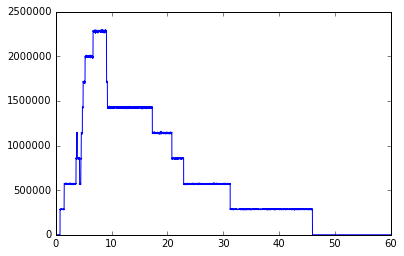

In [4]:
%matplotlib inline
plt.plot(data['0'],data['1'])

N is Number of time levels and is obtained from the length of observations

In [5]:
Wn = np.array(data['1'])
N = len(Wn)  

In [6]:
# Wn[1,N]
Wn = Wn.reshape(1,N)

In [7]:
class FFBS:
    def get_filter(self,A,pi0,pi_filter,N,F):
        A[:,0] = F[:,0]+np.log(pi0)
        #=============================================================================================
        for i in range(1,2):
            A[0,i] = F[0,i]+A[0,i-1]+np.log(pi_filter[0,0])
            #-------------------------------------------------------------------------------------
            MM = np.array([(A[0,i-1]+np.log(pi_filter[0,1])),(A[1,i-1]+np.log(pi_filter[1,1]))])
            Max = -np.max(MM)
            A[1,i] = F[1,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------
            A[2,i] = F[2,i]+A[2,i-1]+np.log(pi_filter[2,2])
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[1,i-1]+np.log(pi_filter[1,3])),(A[3,i-1]+np.log(pi_filter[3,3]))])
            A[3,i] = F[3,i]+np.log(np.sum(np.exp(MM)))
            #--------------------------------------------------------------------------------------                
            A[4,i] = F[4,i]+A[4,i-1]+np.log(pi_filter[4,4])
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[4,i-1]+np.log(pi_filter[4,5])),(A[5,i-1]+np.log(pi_filter[5,5]))])
            Max = -np.max(MM)
            A[5,i] = F[5,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------
            A[6,i] = F[6,i]+A[6,i-1]+np.log(pi_filter[6,6])
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[5,i-1]+np.log(pi_filter[5,7])),(A[7,i-1]+np.log(pi_filter[7,7]))])
            A[7,i] = F[7,i]+np.log(np.sum(np.exp(MM)))
        #=============================================================================================
        for i in range(2,N):
            A[0,i] = F[0,i]+A[0,i-1]+np.log(pi_filter[0,0])
            #-------------------------------------------------------------------------------------
            MM = np.array([(A[0,i-1]+np.log(pi_filter[0,1])),(A[1,i-1]+np.log(pi_filter[1,1]))])
            Max = -np.max(MM)
            A[1,i] = F[1,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------
            A[2,i] = F[2,i]+A[2,i-1]+np.log(pi_filter[2,2])
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[1,i-1]+np.log(pi_filter[1,3])),(A[3,i-1]+np.log(pi_filter[3,3]))])
            Max = -np.max(MM)
            A[3,i] = F[3,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------                
            A[4,i] = F[4,i]+A[4,i-1]+np.log(pi_filter[4,4])
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[4,i-1]+np.log(pi_filter[4,5])),(A[5,i-1]+np.log(pi_filter[5,5]))])
            Max = -np.max(MM)
            A[5,i] = F[5,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------
            A[6,i] = F[6,i]+A[6,i-1]+np.log(pi_filter[6,6])
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[5,i-1]+np.log(pi_filter[5,7])),(A[7,i-1]+np.log(pi_filter[7,7]))])
            Max = -np.max(MM)
            A[7,i] = F[7,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
        
        return A
    
    def emission_distribution(self,Wn,Sn,params,hyper_param,M,ID):
        # This is needed for the calculation of the Filter
        f = hyper_param['f']
        ind = list(range(M))
        ind.remove(ID)
        # Ksn[M,N]
        self.Ksn = np.where(Sn==1,params['k_sigma2'],0.0) 
        # Ksn_filter[8]
        self.Ksn_filter = [0.0,params['k_sigma2'],0.0,0.0,0.0,params['k_sigma2'],0.0,0.0] 
        # self.rate [8,N]
        r = hyper_param['dt']*(params['rho']+np.dot(params['bm'][0,ind],self.Ksn[ind,:]))
        self.rate = [r+hyper_param['dt']*self.Ksn_filter[i] for i in range(2)]   

        likelihood = [((self.rate[0]/f)*np.log(Wn/(params['gain']*f))-scipy.special.loggamma(self.rate[0]/f)),
                      ((self.rate[1]/f)*np.log(Wn/(params['gain']*f))-scipy.special.loggamma(self.rate[1]/f))]
        
        d = []
        d.append(likelihood[0])
        d.append(likelihood[1])
        for i in range(6):
            d.append(likelihood[0])         
        
        return np.vstack(d)
    
    # Filter changes for each particle because of the change in the rates. But transition matrix is the same.
    def Filter(self,pi,pi_filter,N,ID,Sn,Wn,M,params,hyper_param):  
        A = np.zeros([8,N], dtype=np.float64)
        # Likelihood or Emission distribution
        # F[8,N]
        F = self.emission_distribution(Wn,Sn,params,hyper_param,M,ID)     
        
        p1 = hyper_param['gama']/(hyper_param['gama']+M-1)
        # pi0[8,1]
        pi0 = np.array([p1,0,0,0,1-p1,0,0,0])    
    
        return self.get_filter(A,pi0,pi_filter,N,F)
    
    def _FFBS(self,N,pi,pi_filter,params,hyper_param,Sn,Wn):
        # States of the system considered for the filter
        M = hyper_param['N_particles']
        #Snm[8,2]
        Snm = np.column_stack([[1,1,1,1,0,0,0,0],[0,1,2,3,0,1,2,3]]) 
        bm = np.zeros([1,M],dtype=int) 
        for ID in range(M):      
            # A[8,N]
            A = self.Filter(pi,pi_filter,N,ID,Sn,Wn,M,params,hyper_param) 
            # Sanity Check
            if np.sum(A,axis=0).all()==1:
                pass
            else:
                raise Exception('Filter is not working for ID{} with {}'.format(ID,np.sum(A,axis=0)))        
            
            # Sampling via Gumbel distribution
            g_i = -np.log(-np.log(np.random.uniform(size=8)))
            # Get the state at the last time level
            ind_N = np.argmax(g_i+A[:,N-1])          
            # Backward Sampling
            Sn[ID,N-1] = Snm[ind_N,1]
            bm[0,ID] = Snm[ind_N,0]
            # AA[4,N]
            AA = A[:4,:] if ind_N<4 else A[4:,:]                
            for n in range(N-2,-1,-1):
                weight = AA[:,n]+np.log(pi[:,Sn[ID,n+1]])
                g_i = -np.log(-np.log(np.random.uniform(size=4)))
                Sn[ID,n] = np.argmax(g_i+weight) 
          
        return bm, Sn

In [8]:
class Metropolis_Hastings:      
    def _proposal(self,x1,x2,alfa):
        # x1 refers to old and x2 refers to proposal
        return ((2*alfa-1)*(np.log(x1/x2))+alfa*(x2/x1-x1/x2))
    
    def _prior(self,x1,x2,alfa,beta):
        # x1 refers to old and x2 refers to proposal
        return (alfa-1)*np.log(x2/x1)+(x1-x2)/beta

    def _likelihood(self,x1,y1,x2,y2,Sn,params,hyper_param,Wn):            
        f = hyper_param['f']
        Ksn1 = np.where(Sn==1,y1,0.0)  # old
        rate1 = (x1+np.dot(params['bm'],Ksn1))*hyper_param['dt'] # rate1[1,N]
        
        Ksn2 = np.where(Sn==1,y2,0.0)  # prop 
        rate2 = (x2+np.dot(params['bm'],Ksn2))*hyper_param['dt'] # rate2[1,N]
        
        # Likelihood ratio in log format
        L_final = (np.sum(scipy.special.loggamma(rate1/f)-scipy.special.loggamma(rate2/f))+
                   np.sum(np.log(Wn/f)*(rate2-rate1)/f)+
                   np.log(1./hyper_param['beta']+np.sum(Wn)/f)*(np.sum(rate1)-np.sum(rate2))/f+
                   scipy.special.loggamma(hyper_param['alfa']+np.sum(rate2)/f)-
                   scipy.special.loggamma(hyper_param['alfa']+np.sum(rate1)/f))
        
        return L_final

In [9]:
class Gibbs_sampler:  
    def update_gain(self,Wn,Ksn,params,hyper_param):
        f = hyper_param['f']
        alfa_new = hyper_param['alfa']+np.sum((params['rho']+np.dot(params['bm'][0,:],Ksn))*hyper_param['dt'])/f
        beta_new = 1.0/hyper_param['beta']+np.sum(Wn)/f
        
        return np.random.gamma(alfa_new, scale=1.0/beta_new)
    
    def update_rho_ksigma2(self,Sn,Wn,params,hyper_param,repeats,accepted,index_a,index_b):
        MH = Metropolis_Hastings()
        rho_old = params['rho']
        k_sigma2_old = params['k_sigma2']
        
        # Step (a)
        if index_a==1 and index_b==1:
            rho_prop = np.random.gamma(hyper_param['alfa1_proposal'],scale=rho_old/hyper_param['alfa1_proposal'])
            k_sigma2_prop = np.random.gamma(hyper_param['alfa2_proposal'],scale=k_sigma2_old/hyper_param['alfa2_proposal'])

            proposal_ratio = (MH._proposal(rho_old,rho_prop,hyper_param['alfa1_proposal'])+
                    MH._proposal(k_sigma2_old,k_sigma2_prop,hyper_param['alfa2_proposal']))
            prior_ratio = (MH._prior(rho_old,rho_prop,hyper_param['alfa1_prior'],hyper_param['beta1'])+
                 MH._prior(k_sigma2_old,k_sigma2_prop,hyper_param['alfa2_prior'],hyper_param['beta2']))  
            
        elif index_a==1 and index_b==0:
            rho_prop = rho_old  
            k_sigma2_prop = np.random.gamma(hyper_param['alfa2_proposal'],scale=k_sigma2_old/hyper_param['alfa2_proposal'])

            proposal_ratio = MH._proposal(k_sigma2_old,k_sigma2_prop,hyper_param['alfa2_proposal'])                   
            prior_ratio = MH._prior(k_sigma2_old,k_sigma2_prop,hyper_param['alfa2_prior'],hyper_param['beta2'])
            
        else:
            rho_prop = np.random.gamma(hyper_param['alfa1_proposal'],scale=rho_old/hyper_param['alfa1_proposal'])
            k_sigma2_prop = k_sigma2_old
            
            proposal_ratio = MH._proposal(rho_old,rho_prop,hyper_param['alfa1_proposal'])
            prior_ratio = MH._prior(rho_old,rho_prop,hyper_param['alfa1_prior'],hyper_param['beta1']) 
              
            
        likelihood_ratio = MH._likelihood(rho_old,k_sigma2_old,rho_prop,k_sigma2_prop,Sn,params,hyper_param,Wn)
        
        # Step (b)                                
        AR = likelihood_ratio+prior_ratio+proposal_ratio
        
        # Step (c)
        v = np.random.exponential(scale=1)
        
        # Step (d)
        if v>-AR:
            accepted = accepted + 1.0
            return rho_prop, k_sigma2_prop, accepted
        else:
            return rho_old, k_sigma2_old, accepted 
            
    def update_pi(self,Sn,M):
        # total number of transitions for all particles over time 
        # is M*(N-1)
        count = dict({0:{0:0,1:0,2:0,3:0},1:{0:0,1:0,2:0,3:0},
                      2:{0:0,1:0,2:0,3:0},3:{0:0,1:0,2:0,3:0}})
        for j in range(M):
            for i in range(N-1):
                state1 = Sn[j,i]
                if Sn[j,i+1]==0:
                    count[state1][0] += 1
                elif Sn[j,i+1]==1:
                    count[state1][1] += 1
                elif Sn[j,i+1]==2:
                    count[state1][2] += 1
                elif Sn[j,i+1]==3:
                    count[state1][3] += 1
                    
        if count[0][1]>M:
            raise Exception('Wrong transitions are happening')
            
        return count

    def update_weight_State(self,hyper_param,pi,pi_filter,params,Sn,Wn):
        ffbs = FFBS()
        return ffbs._FFBS(N,pi,pi_filter,params,hyper_param,Sn,Wn)
    
    def get_likelihood(self,Wn,Sn,params,hyper_param,M,bm):
        # This is needed for the calculation of the Filter
        f = hyper_param['f']
        Ksn = np.where(Sn==1,params['k_sigma2'],0.0) 
        rate = hyper_param['dt']*(params['rho']+np.dot(bm[0,:],Ksn))
        
        likelihood = ((rate/f)*np.log(Wn)-scipy.special.loggamma(rate/f)-(rate/f)*np.log(f*params['gain']))
        return np.sum(likelihood)
    
    def update_loads(self,hyper_param,params,Sn,Wn,M,pair):
#         pair = random.choice([p for p in itertools.product(range(M), repeat=2)]) 
        loads = np.column_stack([[0,0,1,1],[0,1,0,1]])
        
        p1 = hyper_param['gama']/(hyper_param['gama']+M-1)
        p_ma = np.array([1-p1,1-p1,p1,p1])
        p_mb = np.array([1-p1,p1,1-p1,p1])
        
        weights = []
        for i in range(len(loads)):
            bm = params['bm']
            bm[0,pair[0]] = loads[i,0]
            bm[0,pair[1]] = loads[i,1]
            weights.append(self.get_likelihood(Wn,Sn,params,hyper_param,M,bm)+np.log(p_ma[i])+np.log(p_mb[i]))
            
        g_i = -np.log(-np.log(np.random.uniform(size=4)))
        index = np.argmax(g_i+weights) 
        params['bm'][0,pair[0]] = loads[index,0]
        params['bm'][0,pair[1]] = loads[index,1]
        
        return params['bm']
    
    def likelihood_ratio(self,Wn,Sn,params,hyper_param,M,bm_old,bm_prop):
        # This is needed for the calculation of the Filter
        f = hyper_param['f']
        Ksn = np.where(Sn==1,params['k_sigma2'],0.0) 
        rate_old = hyper_param['dt']*(params['rho']+np.dot(bm_old[0,:],Ksn))
        rate_prop = hyper_param['dt']*(params['rho']+np.dot(bm_prop[0,:],Ksn))
        
        likelihood_ratio = ((rate_prop/f-rate_old/f)*np.log(Wn)+scipy.special.loggamma(rate_old/f)
                     -scipy.special.loggamma(rate_prop/f)+(rate_old/f-rate_prop/f)*np.log(f*params['gain']))
        return np.sum(likelihood_ratio)
    
    def MH_loads(self,hyper_param,params,Sn,Wn,M,accepted,weights_loads):
        p1 = hyper_param['gama']/(hyper_param['gama']+M-1)
        
        bm_old = params['bm']
        bm_prop = ss.bernoulli.rvs(weights_loads).reshape(1,M)
        
        # Step (a)
        likelihood_ratio = self.likelihood_ratio(Wn,Sn,params,hyper_param,M,bm_old,bm_prop)
        
        # Step (b)                                
        AR = likelihood_ratio
        
        # Step (c)
        v = np.random.exponential(scale=1)
        
        # Step (d)
        if v>-AR:
            accepted = accepted + 1.0
            return bm_prop, accepted 
        else:
            return bm_old, accepted 
        
    def update_weight(self,params,hyper_param,M):
        alfa = hyper_param['gama']/M
        beta = (M-1)/M
        alfa_new = alfa+params['bm']
        beta_new = 1+beta-params['bm']
        
        return np.random.beta(alfa_new, beta_new)    

In [10]:
def update_pi_filter(pi):
    aa = np.zeros([4,4],dtype=np.float64)
    d1 = np.column_stack([pi,aa])
    d2 = np.column_stack([aa,pi])
    return np.vstack([d1,d2])

In [11]:
def __main__(pi,Sn,Ksn,params,hyper_param):
    data1 = 'Wn_single1.h5'
    data2 = 'params_single1.h5'
    data3 = 'trajectory_single1.h5'
    data4 = 'load_single1.h5'
    
    data = dict({'B':[], 'ite':[],'E_b':[],'E_ph':[], 'gain':[]})
    M = hyper_param['N_particles']
    gibbs = Gibbs_sampler()
    accepted  = 0.0
    accepted_rho = 0.0
    accepted_ksigma2 = 0.0
    accepted_load = 0.0 
    p = pd.DataFrame()
    for j in range(repeats):
        print(j)
        start1 =  time.time()
        # Metropolis Hastings
#         params['rho'], params['k_sigma2'], accepted = gibbs.update_rho_ksigma2(Sn,Wn,params,hyper_param,repeats,accepted,1,1)
#         params['rho'], params['k_sigma2'], accepted_rho = gibbs.update_rho_ksigma2(Sn,Wn,params,hyper_param,repeats,accepted_rho,1,0)
#         params['rho'], params['k_sigma2'], accepted_ksigma2 = gibbs.update_rho_ksigma2(Sn,Wn,params,hyper_param,repeats,accepted_ksigma2,0,1)

        # Update Gain 
#         params['gain'] = 1./(gibbs.update_gain(Wn,Ksn,params,hyper_param))        

        # Update Transition Probabilities
#         count = gibbs.update_pi(Sn,M)        

#         state = 0 
#         pi[0] = np.array(list(np.random.dirichlet((0.9+count[state][0],0.1+count[state][1])))+[0,0])
#         state = 1
#         pi[1] = np.array([0]+list(np.random.dirichlet((0.5+count[state][1],0.4+count[state][2],0.1+count[state][3]))))
#         state = 2 
#         pi[2] = np.array([0]+list(np.random.dirichlet((0.9+count[state][1],0.1+count[state][2])))+[0])
#         pi[3] = np.array([0,0,0,1])
        
        pi_filter = update_pi_filter(pi)
#         p = pd.concat([p,pd.DataFrame(pi)],axis=0)        
        # Sanity Check
#         if all(np.sum(pi,axis=1))==1 and all(np.sum(pi_filter,axis=1))==1:
#             pass
#         else:
#             raise Exception('probabilities do not sum to 1')      

#         print(params['gain'],params['rho'],params['k_sigma2'])
        
        # FFBS
        params['bm'], Sn = gibbs.update_weight_State(hyper_param,pi,pi_filter,params,Sn,Wn)
        
        # Sample more load for improved mixing  
#         for m in range(M):
#             a = list(range(M))
#             a.remove(m)
#             for m1 in a:
#                 pair = (m,m1)
#                 params['bm'] = gibbs.update_loads(hyper_param,params,Sn,Wn,M,pair)
        
        # MH for smapling all loads
#         for ii in range(30):
#             weights_loads = gibbs.update_weight(params,hyper_param,M)
#             params['bm'], accepted_load = gibbs.MH_loads(hyper_param,params,Sn,Wn,M,accepted_load,weights_loads)
        
        # Sanity Check
        if all(Sn[:,0])==0:
            pass
        else:
            raise Exception('The initial state of the particle is not zero')
            
        # Store the Date
        data['gain'].append(params['gain'])
        data['E_b'].append(params['rho'])
        data['E_ph'].append(params['k_sigma2'])
        data['B'].append(np.count_nonzero(params['bm']))      
        data['ite'].append(j)
    
        # Timing
        start2 = time.time()
        print(start2-start1,np.count_nonzero(params['bm']),accepted/(j+1)*100,accepted_rho/(j+1)*100
                                                 ,accepted_ksigma2/(j+1)*100,accepted_load/(30*(j+1))*100)

        # Save the output
        ## MCMC Chain Parameters
        df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in data.items()]))
        params_data = pd.HDFStore(data2)
        params_data['df{}'.format(j)] = df.loc[j]
        params_data.close()
        
        ## Emission Distribution
        Ksn = np.where(Sn==1,params['k_sigma2'],0.0)
        estimated_emission = (params['rho']+np.dot(params['bm'],Ksn))*hyper_param['dt']*params['gain']
        estimated_emission_final = pd.DataFrame(dict({'ite':range(N),'est':estimated_emission.reshape(N,)}))
        
        if j%100==0:
            emission_data = pd.HDFStore(data1)
            emission_data['df{}'.format(j)] = pd.DataFrame(estimated_emission)
            emission_data.close()
            ## Trajectory of data
            trajectory_data = pd.HDFStore(data3)
            trajectory_data['df{}'.format(j)] = pd.DataFrame(Sn)
            trajectory_data.close()
            ## Loads 
            load_data = pd.HDFStore(data4)
            load_data['df{}'.format(j)] = pd.DataFrame(params['bm'])
            load_data.close()
            
        # Some postprocessing
#         new_data = dict({'E_b': [params['theta']*params['rho']],'E_ph': [params['theta']*params['k_sigma2']],
#                          'B':[np.count_nonzero(params['bm'])],'ite':[j]})
#         plot_traces(estimated_emission_final,new_data,handle)
    
    # Calculate Acceptance Rate
    print ("Acceptance rate = " + str(accepted/repeats*100))
    print ("Acceptance rate rho = " + str(accepted_rho/repeats*100))
    print ("Acceptance rate ksigma2 = " + str(accepted_ksigma2/(30*repeats)*100))

    return data, p

### Hyper-parameters:
dt is the exposure time, alfa & beta are hyper-parameters of Theta, alfa1 & beta1 are hyper-parameters of Rho,
alfa2 & beta2 are hyper-parameters of K_sigma2

In [12]:
repeats = 2000

In [13]:
hyper_param = {'alfa':3.0,'alfa1_proposal':100,'alfa1_prior':2.0,'alfa2_prior':2.0,
               'alfa2_proposal':100,'N_particles':50,'gama':1.0,'dt':0.01*0.95,'f':2.0} 

In [14]:
hyper_param['beta'] = 10.0/hyper_param['alfa']
hyper_param['beta1'] = 5e+3/hyper_param['alfa1_prior']
hyper_param['beta2'] = 3e+06/hyper_param['alfa2_prior']

In [15]:
M = hyper_param['N_particles']

### Parameters to be calculated by Gibbs Sampler 

In [16]:
params = {'gain':1e+1,
          'rho':5e+3,
          'k_sigma2':3e+6,
          'bm':np.random.choice(2,size=M,p=[0.8,0.2]).reshape(1,M)}

#### Note: 
The weights for the transition probability distribution are our hyper-parameters and we assume them.

In [17]:
# pi0 = np.array(list(np.random.dirichlet((0.7,0.3)))+[0,0])
# pi1 = np.array([0]+list(np.random.dirichlet((0.55,0.25,0.2))))
# pi2 = np.array([0]+list(np.random.dirichlet((0.4,0.6)))+[0])
# pi3 = np.array([0,0,0,1])
# pi = np.stack((pi0,pi1,pi2,pi3),axis=0)

In [18]:
pi = np.array([[9.99850011e-01, 1.49913779e-04, 0.00000000e+00, 7.49712573e-08],
               [0.00000000e+00, 9.99000500e-01, 0.00000000e+00, 9.99500167e-04],
               [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
               [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [19]:
pi

array([[9.99850011e-01, 1.49913779e-04, 0.00000000e+00, 7.49712573e-08],
       [0.00000000e+00, 9.99000500e-01, 0.00000000e+00, 9.99500167e-04],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

### Initialize the trajectory of states and rate matrix

#### Note: 
We know that the initial states of all particles is known and they are Inactive at the initial time level 

In [20]:
# Sn1 = pd.read_csv('trajectory_low_SNR_multiple.csv').drop('Unnamed: 0',axis=1).values

In [21]:
Sn = np.zeros([M,N],dtype=np.int)
Sn[:,0] = 0

In [22]:
# for i in range(10):
#     Sn[i:i+10,:] = Sn1 

In [23]:
# Note: Always double check to make sure wrong transitions are not happening, like more than one transition   
# from state zero to state one and from state one to state zero.
for i in range(M):
    for j in range(1,N):
        Sn[i,j] = np.random.choice(4,p=pi[Sn[i,j-1]])  #Sn[M,N] 

In [24]:
Ksn = np.where(Sn==1,params['k_sigma2'],0.0)   # Ksn[M,N]

### Main run

In [25]:
def plot_traces(estimated_emission_final,new_data,handle):
    source.stream(new_data)
    source1.stream(estimated_emission_final)
#     doc.add_periodic_callback(__main__)
    push_notebook(handle=handle)

In [26]:
if __name__ == '__main__':
    if os.path.isfile('Wn_single1.h5'):
        os.remove('Wn_single1.h5')
        os.remove('params_single1.h5')
        os.remove('trajectory_single1.h5')
        os.remove('load_single1.h5')
        
#     output_notebook()
#     source = ColumnDataSource({'E_b':[],'E_ph':[],'B':[],'ite':[]})
#     s1 = figure(width=250, plot_height=250, title=None)
#     s1.scatter(x='ite', y='B', color="navy", alpha=0.5, source=source)
#     s2 = figure(width=250, height=250, title=None)
#     s2.scatter(x='ite', y='E_b', color="firebrick", alpha=0.5, source=source)
#     s3 = figure(width=350, height=250, title=None)
#     s3.scatter(x='ite', y='E_ph', color="olive", alpha=0.5, source=source)  
#     source1 = ColumnDataSource(pd.DataFrame(columns=['ite','est']))
#     s4 = figure(width=350, height=250, title=None)
#     s4.scatter(x='ite', y='est', color="black", alpha=0.5, source=source1)
#     s4.scatter(range(N), Wn, color="blue", alpha=0.5) 
#     pl = gridplot([[s1,s2,s3],[s4]], toolbar_location=None)
#     handle = show(pl, notebook_handle=True, new='window', notebook_url='localhost:8888')
    
    out = __main__(pi,Sn,Ksn,params,hyper_param) 
    # Use line-profiler for optimization
#     lp = LineProfiler()
#     lp.add_function(FFBS._FFBS)
#     lp_wrapper = lp(__main__)
#     lp_wrapper(repeats,M,pi,Sn,Ksn,pl)
#     lp.print_stats(), format='pdf'
#------------------------------------------------------
#     %lprun -f __main__  __main__(repeats,M,pi,Sn,Ksn) 

0
34.75859355926514 46 0.0 0.0 0.0 0.0
1


/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expect

33.08648180961609 26 0.0 0.0 0.0 0.0
2
32.11830544471741 39 0.0 0.0 0.0 0.0
3
30.97716760635376 22 0.0 0.0 0.0 0.0
4
31.313000917434692 28 0.0 0.0 0.0 0.0
5
30.487319707870483 21 0.0 0.0 0.0 0.0
6
30.461066007614136 25 0.0 0.0 0.0 0.0
7
30.683850288391113 20 0.0 0.0 0.0 0.0
8
30.511881113052368 24 0.0 0.0 0.0 0.0
9
30.367944478988647 27 0.0 0.0 0.0 0.0
10
30.743572235107422 26 0.0 0.0 0.0 0.0
11
30.270974159240723 21 0.0 0.0 0.0 0.0
12
31.308600664138794 21 0.0 0.0 0.0 0.0
13
31.264864921569824 20 0.0 0.0 0.0 0.0
14
30.3151752948761 20 0.0 0.0 0.0 0.0
15
30.807449340820312 21 0.0 0.0 0.0 0.0
16
30.29521870613098 20 0.0 0.0 0.0 0.0
17
31.255486488342285 21 0.0 0.0 0.0 0.0
18
30.598150730133057 20 0.0 0.0 0.0 0.0
19
31.396220207214355 20 0.0 0.0 0.0 0.0
20
30.382646560668945 21 0.0 0.0 0.0 0.0
21
29.90023136138916 20 0.0 0.0 0.0 0.0
22
31.40932869911194 20 0.0 0.0 0.0 0.0
23
30.074557781219482 20 0.0 0.0 0.0 0.0
24
30.953632354736328 20 0.0 0.0 0.0 0.0
25
30.012772798538208 20 0.0 0.0 0.

### Postprocessing

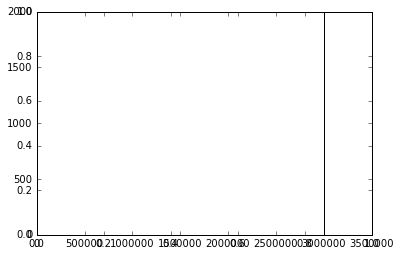

In [27]:
fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
n, bins, patches = plt.hist(out[0]['E_ph'], 50, facecolor='blue')
n1, bins1, patches1 = plt.hist(np.random.gamma(1,1,size=10000)*400, 50, facecolor='red')
ax2.xaxis.set_label_position('top')

In [1]:
data1 = 'Wn_single1.h5'
emission_data = pd.HDFStore(data1)
fig = plt.figure(figsize=(4,4)) 
    
gain = 10 
Miu_b_true = 5e+03
Miu_emission = 3e+06
# Ksn_true = np.where(Sn_true==1,Miu_emission,0.0) 
# Lambda_n = hyper_param['dt']*(Miu_b_true+Ksn_true.sum(axis=0))*gain

plt.style.use('ggplot')
sns.set_style('ticks')
plt.rcParams['font.size'] = 12
for i in range(1500,2000,100):
    plt.plot(range(N),emission_data['df{}'.format(i)].iloc[0])  

plt.scatter(range(N), Wn, color="blue", alpha=0.5)
# plt.scatter(range(N), Lambda_n[0,:], color="red", alpha=0.5)
plt.xlim([0,6000])
# plt.ylim([0,3000])
# plt.ylabel(ylabel)
# plt.xlabel(xlabel)
plt.tight_layout()
sns.despine(offset=10)
# fig.savefig('Emission_distribution.pdf')

NameError: name 'pd' is not defined

In [30]:
df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in out[0].items()]))

FloatingPointError: invalid value encountered in double_scalars

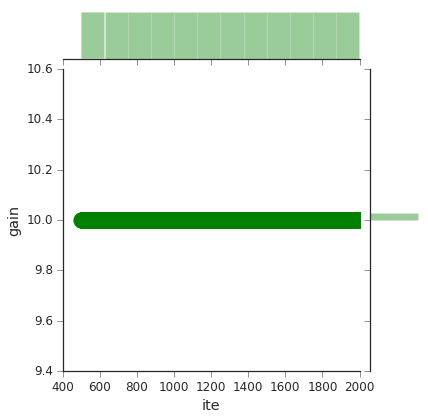

In [31]:
sns_plot = sns.jointplot(x=df['ite'][500:],y=df['gain'][500:], kind='scatter',color='g',s =200,linewidth=2)
sns.set(style="darkgrid", color_codes=False)
# sns_plot.ax_joint.set_ylim([0,300])

(10, 25)

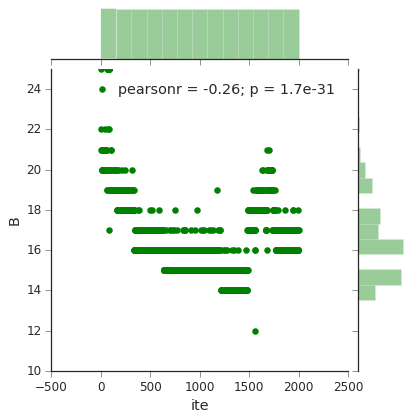

In [33]:
h = sns.jointplot(x=df['ite'],y=df['B'], kind='scatter',color='g',s =20,linewidth=2)
h.ax_joint.set_ylim([10,25])

In [37]:
data3 = 'trajectory_single1.h5'
traj = pd.HDFStore(data3)

In [38]:
ss = traj['df{}'.format(1900)] 

In [39]:
data4 = 'load_single1.h5'
load = pd.HDFStore(data4) 

In [40]:
l = load['df{}'.format(1900)]

In [68]:
active_loads = np.where(l==1)

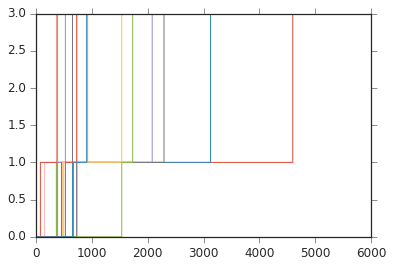

In [69]:
fig, ax1 = plt.subplots()
for i in active_loads[1]:
    ax1.step(x=range(N),y=ss.iloc[i]) 

(0, 6000)

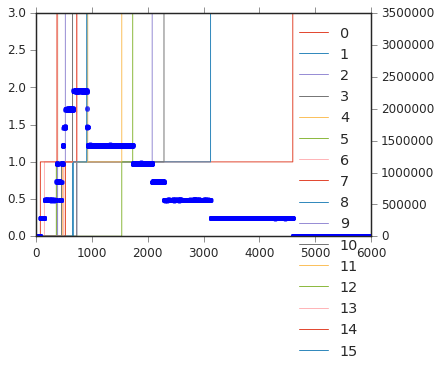

In [61]:
fig, ax1 = plt.subplots()
for i in active_loads[1]:
    ax1.step(x=range(N),y=ss.iloc[i]) 
    
ax2 = ax1.twinx() 
ax2.scatter(range(N), Wn, color="blue", alpha=0.5)
ax2.set_ylim([0,3500000])
ax1.legend()
ax2.set_xlim([0,6000])
# ax1.set_xlim([5000,7000])

In [ ]:
sns_plot = sns.jointplot(x=df['ite'][500:],y=df['E_b'][500:], kind='scatter',color='g',s =200,linewidth=2)
sns.set(style="darkgrid", color_codes=False)
# sns_plot.ax_joint.set_ylim([0,2000])
# sns_plot.savefig('Emission_background.pdf')

In [ ]:
sns_plot = sns.jointplot(x=df['ite'][500:],y=df['E_ph'][500:], kind='scatter',color='g',s =200,linewidth=2)
# sns_plot.ax_joint.set_ylim([0,5000])
# sns_plot.savefig('Photon_Emission.pdf')

In [ ]:
Sn_true = pd.read_csv('trajectory_low_SNR.csv').drop('Unnamed: 0',axis=1).values

step = 0.01
partitions = [i*step for i in range(round(60./step))]
t = partitions

data3 = 'trajectory_single5.h5'
traj = pd.HDFStore(data3)
    
data4 = 'load_single5.h5'
load = pd.HDFStore(data4)    
    
fig = plt.figure(figsize=(4,4)) 
plt.style.use('ggplot')
sns.set_style('ticks')
plt.rcParams['font.size'] = 12
for i in range(100,2000,100):
    for ii in range(len(traj['df{}'.format(i)])):
        if load['df{}'.format(i)].iloc[0,ii]==1:
            plt.step(x=t[:-1],y=traj['df{}'.format(i)].iloc[ii]) 
        
plt.step(x=t[:-1],y=Sn_true[0,:], color="blue") 
# plt.xlim([78,84])

In [ ]:
d = ss.gamma.pdf(np.linspace(1,500,10000),hyper_param['alfa1_prior'],scale=hyper_param['beta1'])

In [ ]:
n, bins, patches = plt.hist(out[0]['E_b'], 500, facecolor='blue')
plt.plot(d*12500,color='k')
plt.xlim([0,500])
# plt.ylim([0,1])
# plt.axvline(1000, color='r')

In [ ]:
n, bins, patches = plt.hist(out[0]['E_ph'], 50, facecolor='blue')
plt.axvline(1e+3, color='r')

In [ ]:
out1 = out[1] 
pi_true = np.array([[9.95012479e-01, 4.39321572e-03, 5.71372296e-04, 2.29327917e-05],
                    [0.00000000e+00, 7.72101222e-01, 2.19089414e-01, 8.80936423e-03],
                    [0.00000000e+00, 8.76357655e-03, 9.91190636e-01, 4.57876835e-05],
                    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
d = dict([(index,0) for index,v in np.ndenumerate(pi)])
for index, x in np.ndenumerate(pi):
    i = index[0]
    j = index[1]
    d[index] = list(out1.iloc[i::4,j])
    
def plot_hist(dic, pi_true):
    fig = plt.figure(figsize=(16,16)) 
    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 12

    nn = 1
    for i, x in np.ndenumerate(pi_true):
        ax = fig.add_subplot(4,4,nn)
        n, bins, patches = plt.hist(dic[i], 10, facecolor='blue')
        plt.axvline(pi_true[i], color='r')
#         ax.set_title(r'$particle-ID: {}$'.format(str(i)))
#         ax.legend().set_visible(False)
        sns.despine(offset=12,ax=ax,trim=True)
        nn = nn+1

    # plt.subplots_adjust(top=0.92,bottom=0.08,left=0.1,right=0.95,wspace=0.6,hspace=0.6)
    plt.tight_layout()
    plt.show() 
#     fig.savefig('Probability_distribution.pdf')
    return None

In [ ]:
plot_hist(d, pi_true)